In [377]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import operator
import random
import matplotlib.pyplot as plt

In [378]:
class User(object):
    def __init__(self, user_id):
        self.id = user_id
        self.artist_weight = {}
        self.tags = {}
        self.artist_tag = {}
        self.friends = []
        self.expert_score = 0
        self.group_number = 0
        
    def add_artist_weight(self, artist_id, weight):
        self.artist_weight[artist_id] = weight
        
    def add_artist_tag(self, artist_id, tag):
        #Record tags that the user tagged
        if tag in self.tags:
            self.tags[tag] += 1
        else:
            self.tags[tag] = 1
            
        #Record artists that user tagged
        if artist_id in self.artist_tag:
            self.artist_tag[artist_id] += 1
        else:
            self.artist_tag[artist_id] = 1
            
        #Record number of tags that user tagged
        self.expert_score += 1
    
    def add_friend(self, user):
        self.friends.append(user)
    
    def get_artist_weight(self):
        return self.artist_weight
    
class Artist(object):
    def __init__(self, artist_id):
        self.id = artist_id
        self.tag_count = {}
        self.listened_times = 0  #Can express popularity
    
    def add_weight(self, weight):
        self.listened_times += weight
    def add_tag (self, tag):
        if tag in self.tag_count:
            self.tag_count[tag] += 1
        else:
            self.tag_count[tag] = 1


**Load data**

In [379]:
def prepareData():
    '''Read data from the files and store the data in the object member variables'''
    '''Returns dictionaries of users and artists'''
    
    users = {}    #Key: userId, Value: User object
    artists = {}  #Key: artistId, Value: Artist object
    
    user_artists = pd.read_csv("user_artists.dat", sep='\t', skiprows=0)
    #print(user_artists.head())
    
    user_tag = pd.read_csv("user_taggedartists.dat", sep='\t', skiprows=0)
    #print(user_tag.head())
    
    user_friends = pd.read_csv("user_friends.dat", sep='\t', skiprows=0)
    #print(user_friends.head())
    
    
    # Create User and Artist objects and populate member variables
    
    # Add artist and weight into User
    
    for index, row in user_artists.iterrows():
        if row['userID'] not in users:  
            user = User(row['userID'])
            users[row['userID']] = user
        else:
            user = users[row['userID'] ]
        user.add_artist_weight(row['artistID'], row['weight'])
    
    # Add weight into Artist

        if row['artistID'] not in artists:
            artist = Artist(row['artistID'])
            artists[row['artistID']] = artist
        else:
            artist = artists[row['artistID']] 
        artist.add_weight(row['weight'])
                  
    
    # Add artist and tag into User
    
    for index, row in user_tag.iterrows():
        if row['userID']  not in users:
            print("Unknown user!!")
        else:
            user = users[row['userID'] ]
            user.add_artist_tag(row['artistID'], row['tagID'])
    
    # Add tag into Artist
    
        if row['artistID'] not in artists:
            # Artists were tagged by a user even it is not in user_artist.dat
            #print("Unknown artist: ", row['artistID'])
            artist = Artist(row['artistID'])
            artists[row['artistID']] = artist
        else:
            artist = artists[row['artistID']] 
        artist.add_tag(row['tagID'])
    
    #Add friends into User
    
    for index, row in user_friends.iterrows():
        if row['userID']  not in users:
            print("Unknown user!!")
        else:
            user = users[row['userID'] ]
            friend = users[row['friendID']]
            user.add_friend(friend)
    return(users, artists)

In [380]:
users, artists = prepareData()
print("Number of users: ", len(users))
print("Number of artists: ", len(artists))

Number of users:  1892
Number of artists:  18022


**Extract features**

In [374]:
def extractFeatures(users, artists):
    '''Create features '''
    '''Returns sparse np array of features'''
    
    artistTags = np.zeros((18746, 12648))
    for artId in artists.keys():
        for tagId in (artists[artId].tag_count.keys()):
            artistTags[artId][tagId] = artists[artId].tag_count[tagId]

    userArtists = np.zeros((2101, 18746))
    userGenres = np.zeros((2101, 12648))

    for userId in users.keys():
        for artId in (users[userId].artist_weight.keys()):
            userArtists[userId][artId] = users[userId].artist_weight[artId]
        
        for tagId in (users[userId].tags.keys()):
            userGenres[userId][tagId] = users[userId].tags[tagId]     
    
    userArtists = normalize((userArtists))
    artistTags = normalize((artistTags))
    userGenres = normalize((userGenres))
    
    return userArtists, artistTags, userGenres

**Build a model**

In [392]:
'''Group users using K-Means Clustering'''
'''We should choose n_clusters that gives us the best result'''
kmeans = KMeans(n_clusters=30, random_state=0).fit(userArtists)     

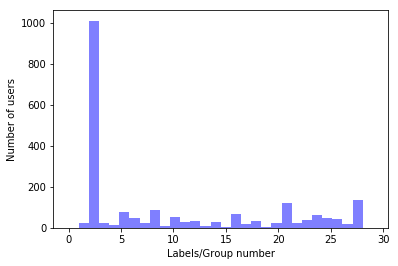

In [393]:
plt.hist(kmeans.labels_, 30, facecolor='blue', alpha=0.5)
plt.xlabel('Labels/Group number')
plt.ylabel('Number of users')
plt.show()

**Predict**

In [397]:
def calculateSimilariy(data):
    #Calculate similarities between users based on their euclidean distances
    #Input userArtists space array
    distance = euclidean_distances(data, data)   
    return distance

def assignGroup(users, labels):    
    #Assign each user's group
    for i in range(len(labels)):
        if i in users:
            users[i].group_number = labels[i]

def findGroupExpert(users):
    #Find an expert in each group
    
    group_expert = {}
    
    for userId in users.keys():        
        if users[userId].group_number in group_expert:
            if (group_expert[users[userId].group_number].expert_score < users[userId].expert_score):
                group_expert[users[userId].group_number] = users[userId]
        else:
            group_expert[users[userId].group_number] = users[userId]
    return group_expert

def recommend(user, groupExpert):
    experts_artist_weight = groupExpert[user.group_number].get_artist_weight()
    sorted_experts_artist_weight = sorted(experts_artist_weight.items(), key=operator.itemgetter(1))
   # return (sorted_experts_artist_weight[-10:])
    return (sorted_experts_artist_weight)

In [412]:
assignGroup(users, kmeans.labels_)
group_expert = findGroupExpert(users)
print("Group ExpertScore")
for keys in group_expert:
    print("%5d%8d" %(group_expert[keys].group_number, group_expert[keys].expert_score))

Group ExpertScore
   18    1500
    2    2075
    5    2609
   23     568
   20     233
   21    1687
   28    1301
    7     788
    6     672
    8     564
    3    1122
   12     460
   24     827
   16     861
   14     405
   10    1018
   22     678
   26     712
    4      62
    9      57
   25    1069
    1     623
   27     570
   11     269
   17     115
   15      41
   13    1521
   19     162
   29      45
    0      12


In [433]:
testSize = 0.2

targetTestSize = len(users)*testSize
print("Number of test users: ", targetTestSize)

print("Intersection of experts artirst and users artists")

all_results = 0
user_count = 0
for i in range(int(targetTestSize)):
    #Choose a user randomly
    index = np.random.choice((range(0, 2101)), replace=False)
    if index not in users:
        continue
    rec_list = recommend(users[index], group_expert)
    users_artist = users[index].get_artist_weight()
    
    hit = 0
    for rec in rec_list:
        if rec[0] in users_artist:
            hit += 1
    result = hit/len(rec_list)
    print(result)
    all_results += result
    user_count += 1   #Since some of the index don't exist
    
print("Average: ", all_results/user_count)

Number of test users:  378.40000000000003
Intersection of experts artirst and users artists
0.3
0.0
0.38
0.02
0.04
0.0
0.1
0.24
0.3
0.04
0.18
0.02
0.02
0.0
0.36
0.0
0.06
0.02
0.32
0.36
0.1
0.0
0.06
0.3
0.04
0.22
0.04
0.0
0.06
0.0
0.04
0.18
0.2
0.1
0.12
0.06
0.12
0.06
0.02
0.06
0.08
0.06
0.16
0.1
0.0
0.26
0.32
0.2
0.44
0.16
0.02
0.24
0.06
0.1
0.0
0.14
0.08
0.18
0.2
0.02
0.14
0.36
0.0
0.08
0.02
0.14
0.0
0.02
0.24
0.08
0.22
0.28
0.0
0.18
0.34
0.24
0.02
0.46
0.06
0.04
0.02
0.22
0.0
0.18
0.0
0.2
0.14
0.0
0.12
0.0
0.14
0.04
0.1
0.02
0.06
0.3
0.08
0.06
0.08
0.2
0.34
0.0
0.14
0.2
0.0
0.38
0.06
0.02
0.08
0.06
0.36
0.02
0.06
0.46
0.06
0.02
0.18
0.22
0.16
0.24
0.34
0.02
0.26
0.14
0.0
0.24
0.16
0.04
0.04
0.04
0.06
0.04
1.0
0.24
0.26
0.02
0.28
0.3
0.2
0.12
0.1
0.06
0.04
0.26
0.0
0.22
0.02
0.12
0.24
0.14
0.24
0.08
0.02
0.2
0.34
0.08
0.1
0.04
0.2
0.0
0.06
0.16
0.12
0.02
0.04
0.24
0.18
0.0
0.24
0.08
0.3
0.2
0.32
0.0
0.16
0.26
0.22
0.0
0.06
0.16
0.04
0.52
0.06
0.06
0.06
0.0
0.0
0.02
0.24
0.04
0.12
0.12